In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# зафиксируем сид для воспроизводимости результатов
RANDOM_SEED = 42
np.random.seed(42)

In [21]:
data = pd.read_csv("microarray_BRCA_public.csv")
data.shape

(120, 54676)

In [22]:
target = "type"
features = data.columns[1:]

In [23]:
data.head()

,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,basal,10.653314,7.385997,6.276376,7.589337,3.264221,6.516051,5.421516,5.141215,9.339500,...,12.459835,11.880859,13.978481,13.625455,6.921081,5.126022,5.371172,2.887719,3.677862,3.039207
1,basal,9.562033,8.619604,6.403856,7.511549,3.116106,6.755821,5.140356,4.454047,7.912255,...,11.875932,11.318290,13.592611,13.317422,7.223960,6.150911,6.227012,2.922538,3.429966,3.126399
2,basal,10.793782,8.432082,5.414666,7.643413,3.397578,6.308265,5.310103,5.076884,5.375713,...,12.473305,11.830756,13.896080,13.577114,6.968871,4.549014,5.021270,2.952320,3.731357,3.103301
3,luminal_A,10.465236,7.227769,5.872487,7.817099,3.261850,7.679108,5.484061,4.765862,6.815736,...,12.627267,12.020696,14.261603,14.065850,8.318827,6.978756,7.403238,2.890106,3.486187,3.149925
4,basal,10.025334,8.194565,6.677015,6.968076,3.249106,7.364889,5.004044,4.800022,7.669665,...,12.228213,11.747489,13.911897,13.600270,7.035046,4.406658,4.828943,3.040227,3.723065,3.189902


In [24]:
# проверим наличие нанов в данных
data.isna().sum().sum()

0

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
data[target].value_counts()

basal        34
luminal_B    24
luminal_A    23
HER          21
cell_line    11
normal        7
Name: type, dtype: int64

Закодируем классы цифрами, чтобы в будущем с ними было проще работать в будущем.

In [27]:
from sklearn.preprocessing import LabelEncoder

In [28]:
le = LabelEncoder()
data[target] = le.fit_transform(data[target])

In [29]:
classes = dict()
for i, class_name in enumerate(le.classes_):
  classes[class_name] = i
classes

{'HER': 0,
 'basal': 1,
 'cell_line': 2,
 'luminal_A': 3,
 'luminal_B': 4,
 'normal': 5}

Разобьем данные на тренировочную и валидационную выборки, сохраняя пропорции классов в них.

In [30]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED, stratify=data[target])

В качестве бейзлайна используем лог. регрессию.

In [31]:
from sklearn.linear_model import LogisticRegression

In [158]:
def fit_predict_logreg(X_train, y_train, X_test, max_iter):
  log_reg = LogisticRegression(max_iter=max_iter)
  log_reg.fit(X_train, y_train)
  pred = log_reg.predict(X_test)

  return log_reg, pred

In [34]:
baseline, base_pred = fit_predict_logreg(data_train[features], data_train[target], data_test[features], max_iter=1000)

In [37]:
from sklearn.metrics import f1_score

In [38]:
f1_score(data_test[target], base_pred, average='macro')

0.9305555555555555

Теперь нашей целью будет побить этот результат бейзлайна.
В качестве метрики использовали macro f1 score, т к это целевая метрика в этой домашке.


In [6]:
def calculate_mistakes(pred, gt):
  mask = (pred != gt)
  mistakes = gt[mask]
  labels, counts = np.unique(mistakes, return_counts=True)

  return dict(zip(labels, counts))

In [40]:
! pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=094bf9d975f2db3f6108a18c7e00c9b84ce48800bb10c1c3a6a9f21c2d61ca70
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=e9db9b9e1b90ed11ff125fd0fc0783ca44d54725c70bcd3f3fa1828a2b4ee880
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


Поизучаем маломерные представления нашей тернировочной выборки. Для этого используем UMAP.

In [43]:
import umap

In [44]:
def train_and_plot_umap(dataset, features):
  umaper = umap.UMAP(random_state=RANDOM_SEED)
  umaped_data = umaper.fit_transform(dataset[features])

  fig, ax = plt.subplots()
  scatter = ax.scatter(umaped_data.T[0], umaped_data.T[1], c=dataset[target])
  legend = ax.legend(*scatter.legend_elements())
  ax.add_artist(legend)
  plt.show()

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


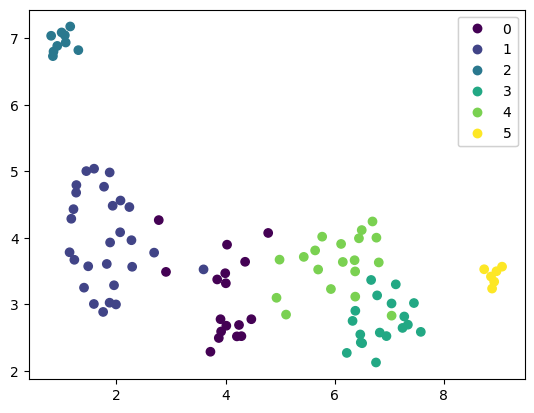

In [45]:
train_and_plot_umap(data_train, features)

В маломерном представлении два класса линейно отделимы от остальных, скорее всего, проблемы будут с перемешанными классами.  
Посмотрим на распределения признаков для различных экземпляров.

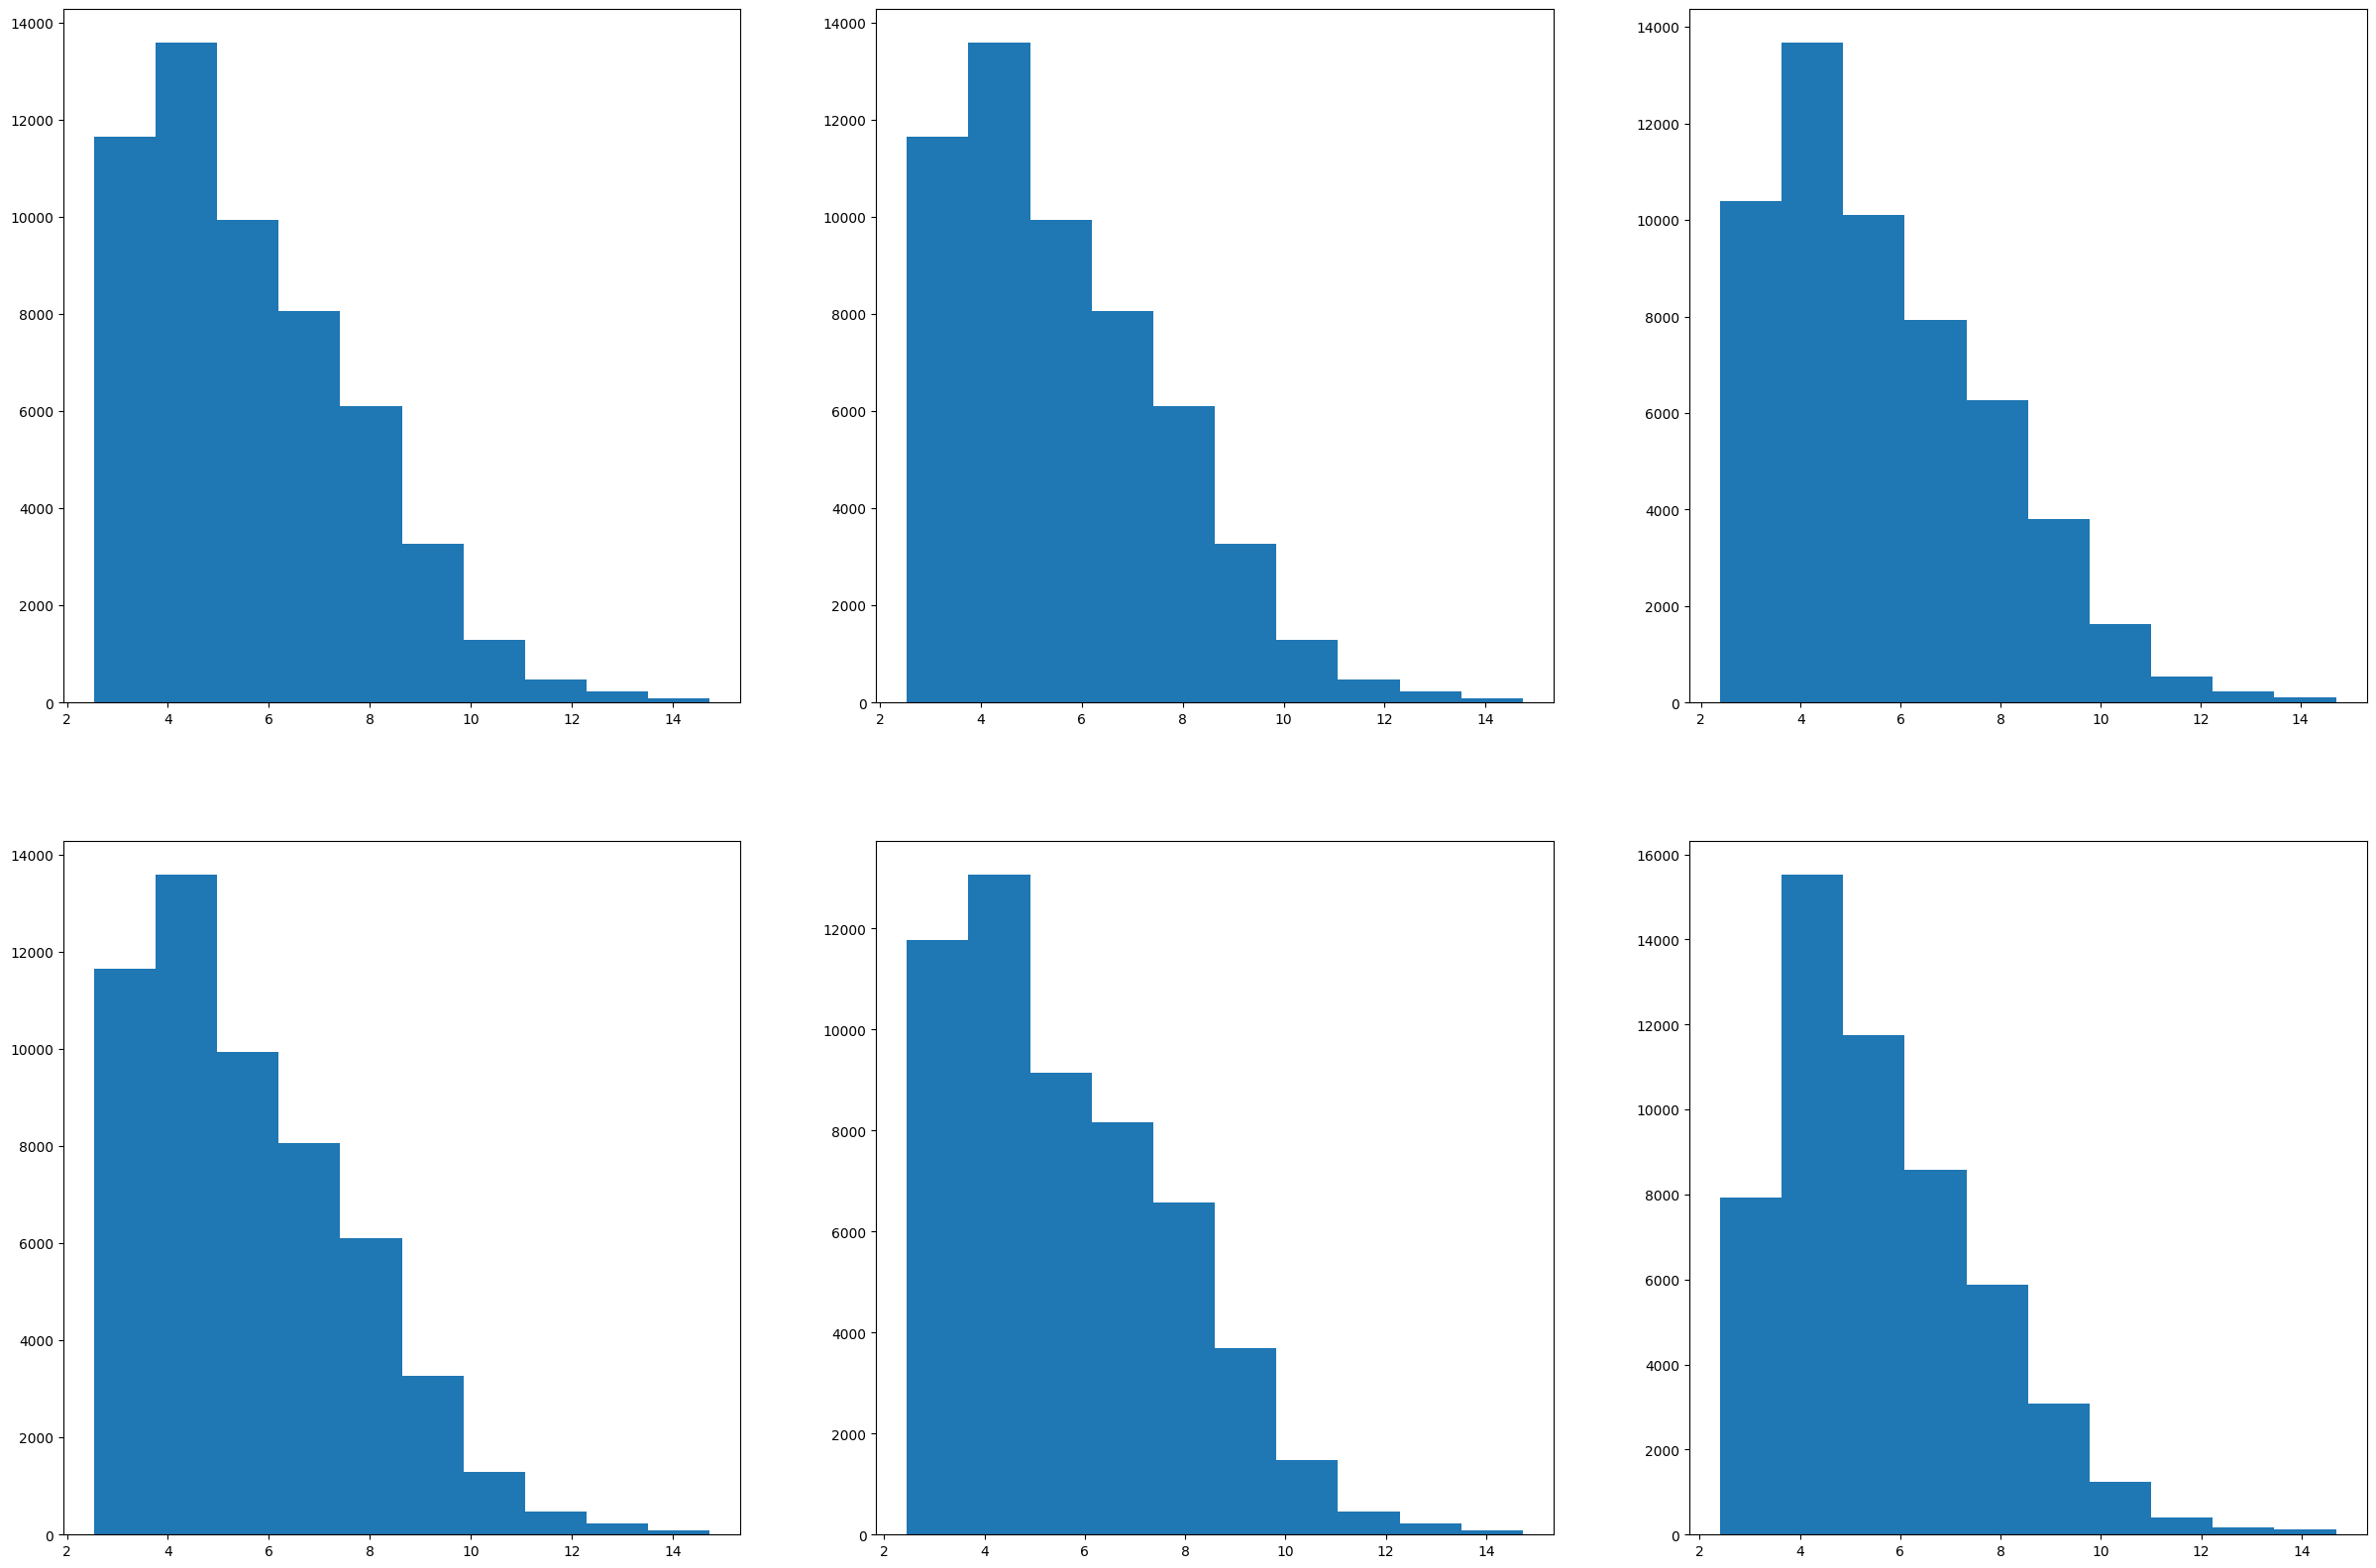

In [62]:
n_samples = 6
ids = np.random.choice(data_train.index, size=n_samples)
plt.figure(figsize=(30, 20))
for i, id in enumerate(ids):
  plt.subplot(2, 3, i + 1)
  plt.hist(data_train.loc[id][1:])

При использовании линейный моделей, такие распределения лучшелог-нормировать.

In [63]:
log_data = np.log(data_train[features])

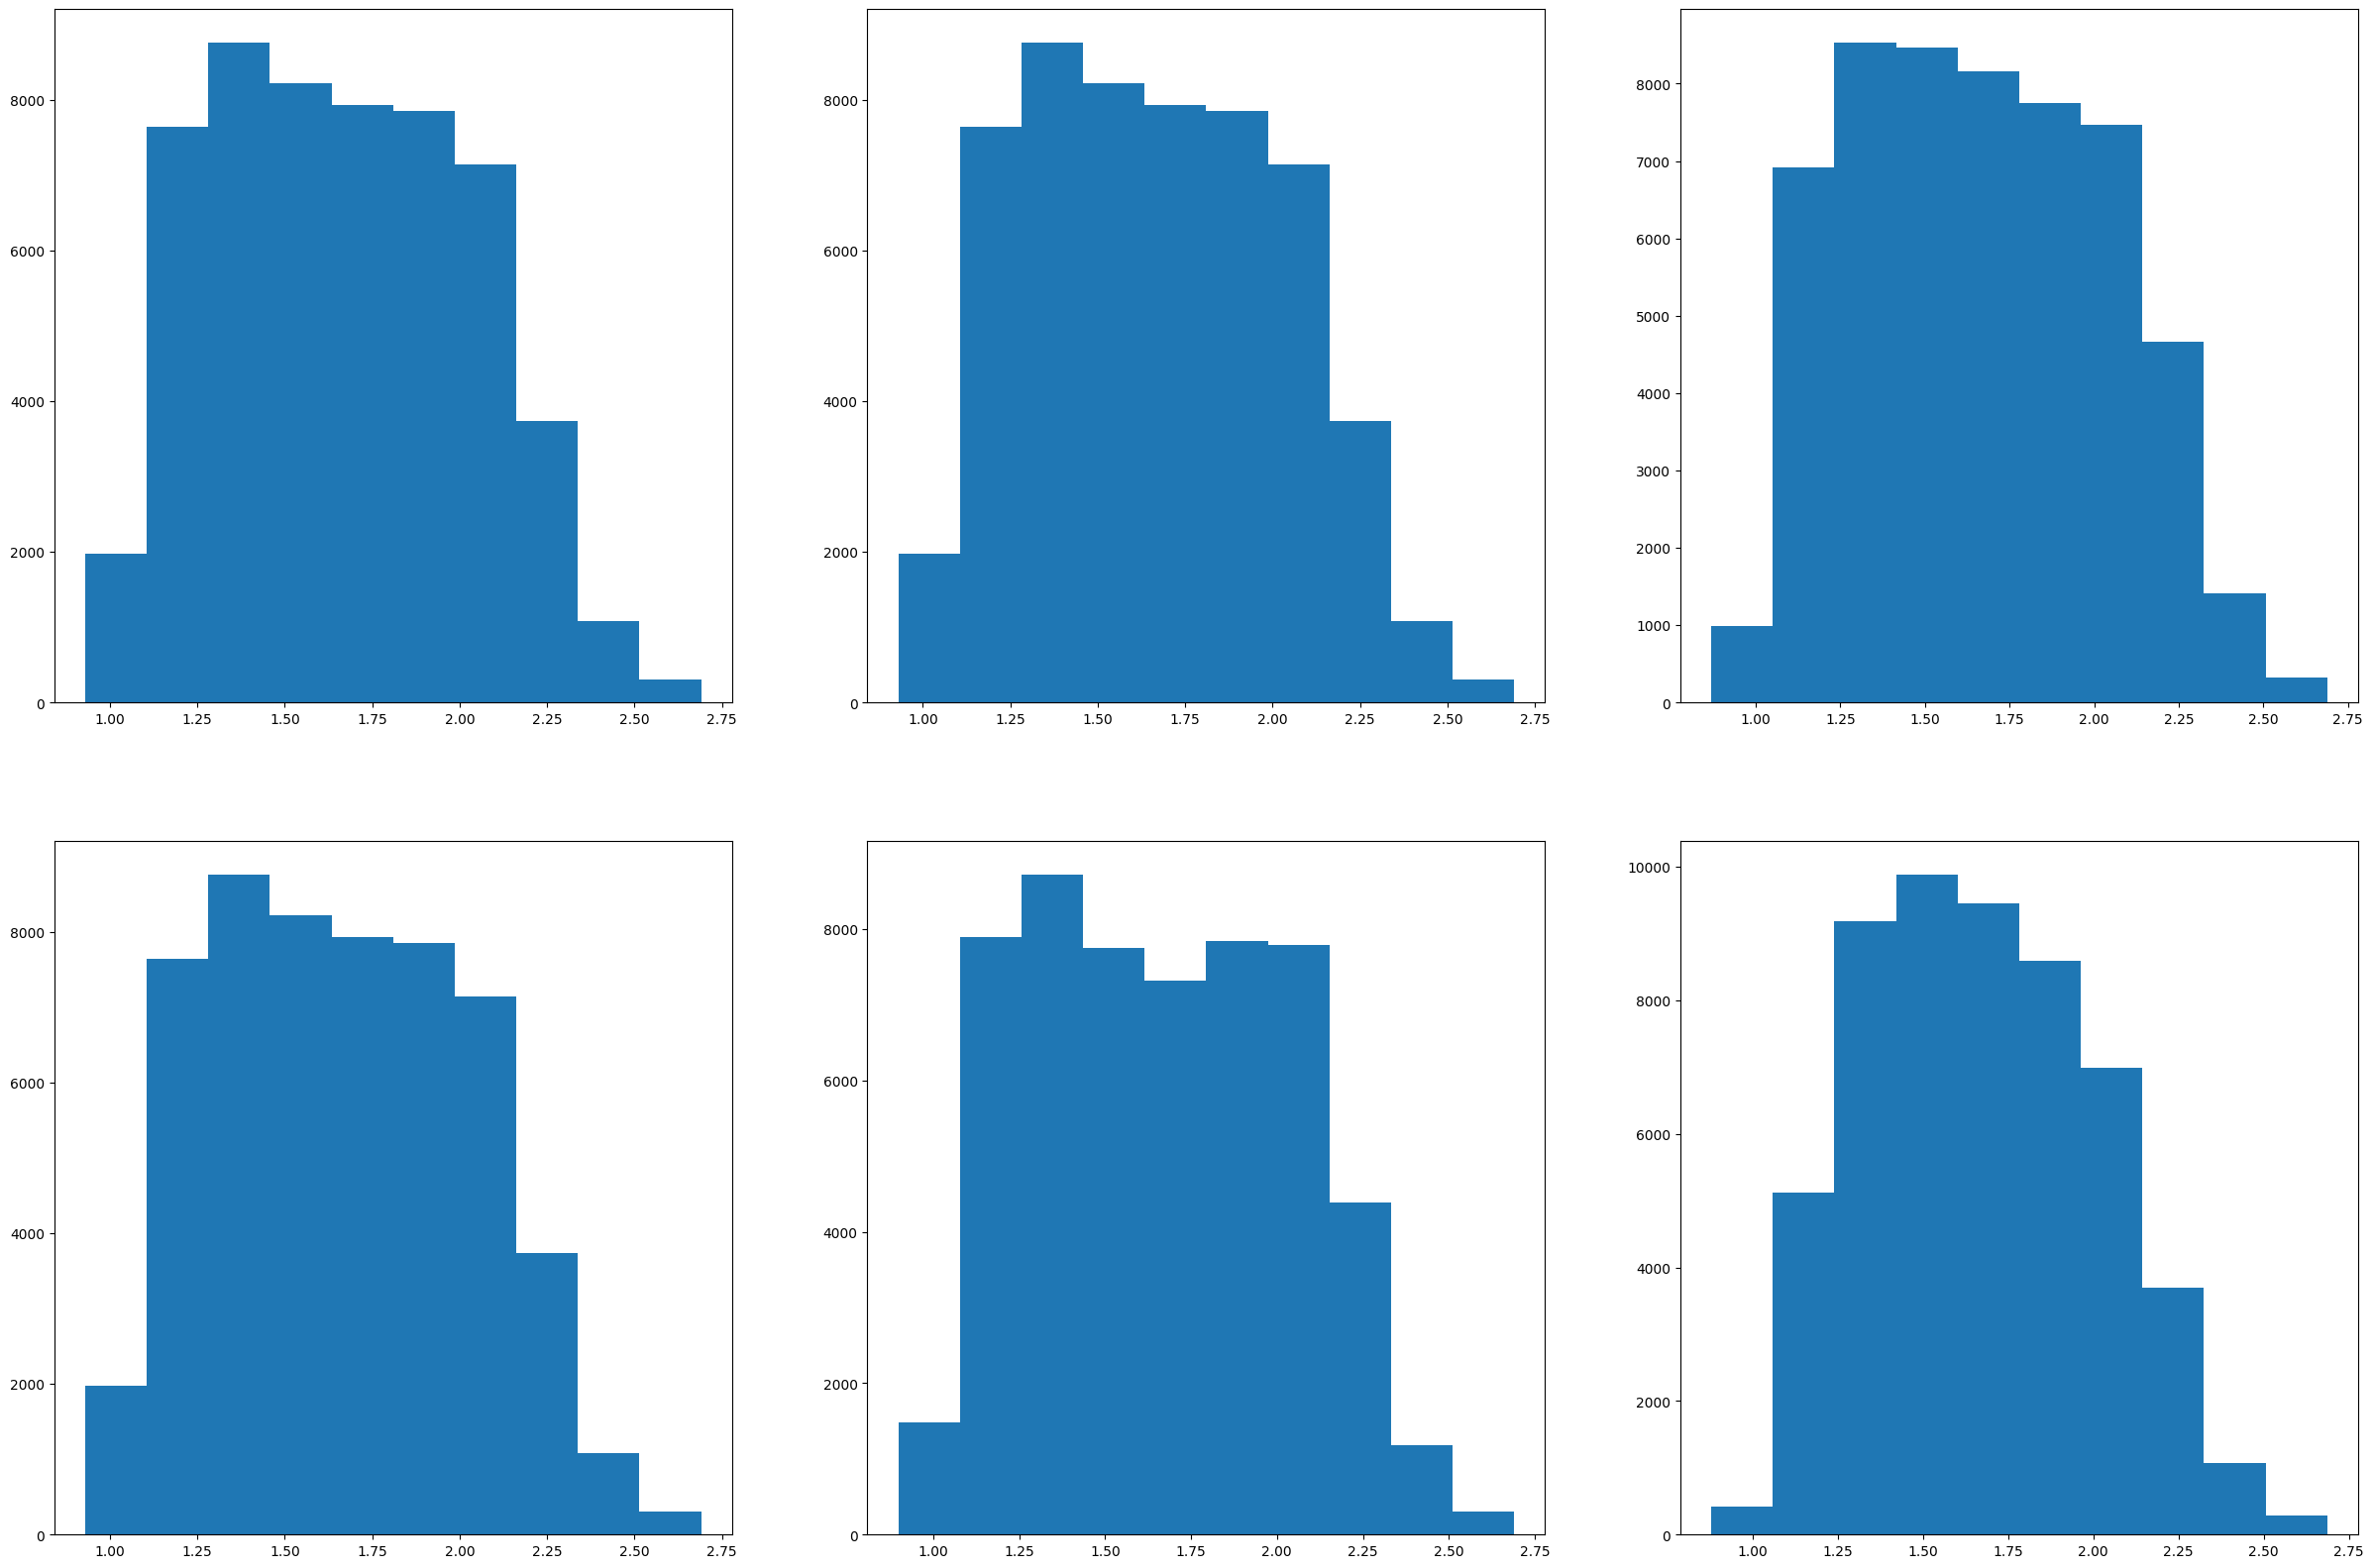

In [64]:
plt.figure(figsize=(30, 20))
for i, id in enumerate(ids):
  plt.subplot(2, 3, i + 1)
  plt.hist(log_data.loc[id][1:])

После лог-нормализации распределения выглядят более централизованными, что будет безусловным плюсом при использовании линейных моделей.
(в аргумент логарифма не поставили +1, потому что значения признзнаков больше единицы).

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


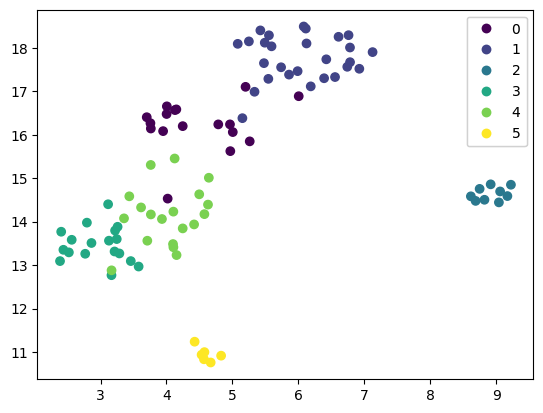

In [70]:
train_and_plot_umap(pd.concat([log_data, data_train[target]], axis=1), features)

После лог нормализации классы чуть перемешались.  
Посомтрим, как это повлияет на предсказание лог регрессии.

In [179]:
_, pred_log = fit_predict_logreg(log_data, data_train[target], np.log(data_test[features]), max_iter=1000)

In [181]:
calculate_mistakes(pred_log, data_test[target]), f1_score(data_test[target], pred_log, average="macro")

({3: 2}, 0.9305555555555555)

Модель пока ошибается только на одном классе, попробуем поработать с данными, чтобы это исправить.  
Попробуем отнормировать наши признаки.

In [71]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [72]:
scaler = StandardScaler()

In [116]:
scaled_log_data = scaler.fit_transform(log_data)

In [125]:
scaled_log_data = pd.DataFrame(data=scaled_log_data, columns=features, index=data_train.index)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


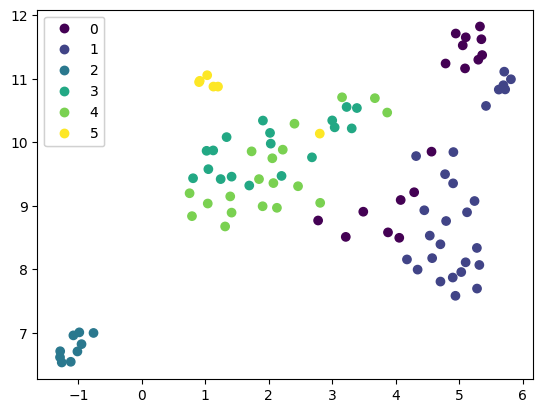

In [127]:
train_and_plot_umap(pd.concat([scaled_log_data, data_train[target]], axis=1), features)

In [182]:
_, pred_log_scale = fit_predict_logreg(log_data, data_train[target], np.log(data_test[features]), max_iter=1000)

In [183]:
calculate_mistakes(pred_log_scale, data_test[target]), f1_score(data_test[target], pred_log_scale, average="macro")

({3: 2}, 0.9305555555555555)

После номрализации классы перемешались еще сильнее в маломерной проекции, однако, это не повлияло на работу модели.

Теперь попробуем понизить размерность данных, чтобы избавитья от шума в них.

In [128]:
pca_train = PCA(n_components=96)

In [129]:
pca_train.fit(scaled_log_data)

PCA(n_components=96)

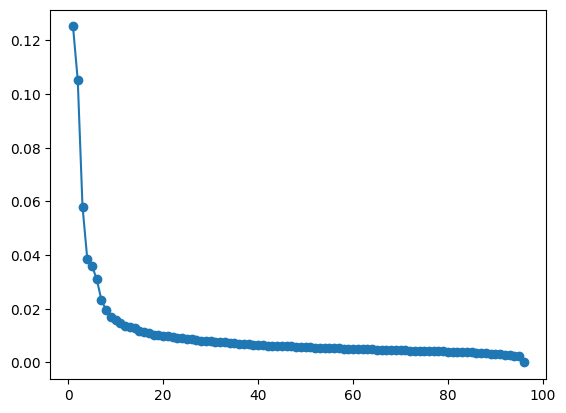

In [130]:
plt.plot(np.arange(1, 97), pca_train.explained_variance_ratio_, 'o-')

Почему оставиди 20 PCA

In [230]:
pca_train.explained_variance_ratio_[:20].sum()

0.5879239210362246

In [231]:
n_components = 20
pca = PCA(n_components=n_components)

In [195]:
log_scaled_pca_data = pca.fit_transform(scaled_log_data)

In [196]:
log_scaled_pca_data = pd.DataFrame(data=log_scaled_pca_data, columns=np.arange(n_components), index=data_train.index)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


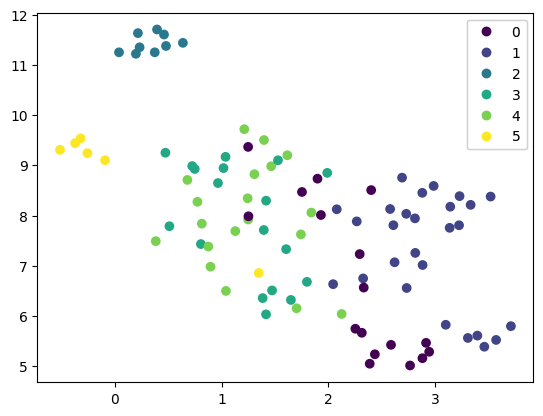

In [197]:
train_and_plot_umap(pd.concat([log_scaled_pca_data, data_train[target]], axis=1), np.arange(n_components))

In [198]:
log_test_data = np.log(data_test[features])
scaled_log_test_data = scaler.transform(log_test_data)
pca_scaled_log_test_data = pca.transform(scaled_log_test_data)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [199]:
scale_logreg, scale_logreg_pred = fit_predict_logreg(log_scaled_pca_data, data_train[target], pca_scaled_log_test_data, max_iter=1000)

In [200]:
calculate_mistakes(scale_logreg_pred, data_test[target])

{1: 1, 3: 2}

In [201]:
f1_score(data_test[target], scale_logreg_pred, average="macro")

0.8992165242165241

При оставлении 20 гланых компонент качество только ухудшилось, потому что почти все компоненты достаточно информативны. (пробавалось взять 30, 50 и 80 главных компонент, это не улучшило работу).

Посмотрим, как на наших данных будет работаь нелинейная модель.

In [202]:
from xgboost import XGBClassifier

In [203]:
clf = XGBClassifier()

In [204]:
clf.fit(data_train[features], data_train[target])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [205]:
boost_pred = clf.predict(data_test[features])

In [207]:
calculate_mistakes(boost_pred, data_test[target]), f1_score(data_test[target], boost_pred, average="macro")

({0: 2, 3: 1, 4: 1}, 0.8111111111111112)

In [210]:
boost_pred_train = clf.predict(data_train[features])
calculate_mistakes(boost_pred_train, data_train[target]), f1_score(data_train[target], boost_pred_train, average="macro")

({}, 1.0)

На ненормированных данных качевсто хуже, чем  у линейной регресии, попробуем бустингом разделить только "скученные" классы в центре.

In [208]:
mask_1 = (data_train[target] != 2).values
mask_2 = (data_train[target] != 5).values
mask = mask_1 * mask_2

In [211]:
small_train = data_train[mask]

In [212]:
clf = XGBClassifier()

In [215]:
new_le = LabelEncoder()

In [216]:
new_le.fit_transform(small_train[target])

array([0, 0, 3, 3, 2, 2, 1, 1, 3, 1, 2, 3, 1, 3, 3, 1, 2, 0, 0, 1, 1, 0,
       2, 3, 1, 3, 2, 2, 1, 3, 2, 0, 2, 3, 1, 2, 3, 3, 1, 1, 1, 2, 0, 1,
       1, 2, 2, 0, 2, 3, 0, 1, 1, 3, 2, 1, 0, 1, 1, 1, 3, 0, 2, 1, 0, 3,
       0, 1, 0, 0, 0, 0, 3, 2, 1, 3, 1, 1, 3, 2, 1])

In [218]:
clf.fit(small_train[features], new_le.transform(small_train[target]))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [219]:
mask_1_test = (data_test[target] != 2).values
mask_2_test = (data_test[target] != 5).values
mask_test = mask_1_test * mask_2_test

In [220]:
small_test = data_test[mask_test]

In [224]:
pred_small = clf.predict(small_test[features])
calculate_mistakes(pred_small, new_le.transform(small_test[target])), f1_score(new_le.transform(small_test[target]), pred_small, average="macro")

({0: 1, 1: 1, 3: 2}, 0.8033882783882783)

In [225]:
new_le.inverse_transform([0, 1, 3])

array([0, 1, 4])

Бустинг все равно не справляется.

Попробуем выбить качесвто на кросс-валидации, может у нас просто не очень удачное разбиение на тренировочную и валидационную выборки.

In [238]:
from sklearn.model_selection import KFold

In [243]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [263]:
best_f1 = 0
best_model = None
best_scaler = None

In [264]:
for i, (train_ids, test_ids) in enumerate(kf.split(data)):
  model = LogisticRegression(max_iter=1000)
  train_folds = data.iloc[train_ids]
  test_fold = data.iloc[test_ids]

  train_feat = np.log(train_folds[features])
  scaler = StandardScaler()
  train_feat = scaler.fit_transform(train_feat)

  model.fit(train_feat, train_folds[target])
  test_feat = np.log(test_fold[features])
  test_feat = scaler.transform(test_feat)

  pred = model.predict(test_feat)
  curr_f1 = f1_score(test_fold[target], pred, average="macro")
  mistakes = calculate_mistakes(pred, test_fold[target])

  if best_f1 < curr_f1:
    best_f1 = curr_f1
    best_model = model
    best_scaler = scaler
  print(f"{i}: f1={curr_f1}, mistakes={mistakes}")

0: f1=0.9484126984126983, mistakes={0: 2}
1: f1=0.8857142857142857, mistakes={0: 1, 1: 1, 5: 1}
2: f1=0.9692307692307691, mistakes={3: 1}
3: f1=0.9198257080610022, mistakes={1: 1, 4: 1}
4: f1=0.9692307692307691, mistakes={4: 1}


In [265]:
best_f1 = 0
best_boost = None

for i, (train_ids, test_ids) in enumerate(kf.split(data)):
  model = XGBClassifier()
  train_folds = data.iloc[train_ids]
  test_fold = data.iloc[test_ids]

  train_feat = np.log(train_folds[features])

  model.fit(train_feat, train_folds[target])
  test_feat = np.log(test_fold[features])

  pred = model.predict(test_feat)
  curr_f1 = f1_score(test_fold[target], pred, average="macro")
  mistakes = calculate_mistakes(pred, test_fold[target])

  if best_f1 < curr_f1:
    best_f1 = curr_f1
    best_boost = model
  print(f"{i}: f1={curr_f1}, mistakes={mistakes}")

0: f1=0.8650793650793651, mistakes={4: 1, 5: 1}
1: f1=0.8984126984126983, mistakes={2: 1, 5: 1}
2: f1=0.8900699300699302, mistakes={3: 1, 4: 2}
3: f1=0.9208576998050683, mistakes={2: 1, 4: 1}
4: f1=0.8578621378621378, mistakes={0: 1, 1: 1, 4: 1}


In [262]:
best_model, best_scaler, best_boost

(LogisticRegression(max_iter=1000), StandardScaler())

С поомщью линейной регресии получилось добиться f1 скора 0.97, что эквивалентно ошибке на одном примере.  
В принципе, за качеством дальше гнаться некуда.  
Для прогона на тесте, возьмите бейзлайн и логрег с нормализацией.
Бейзлайн: просто логрег.  
Логрег с нормализацией:  
1) Лог нормализация  
2) StandardScaler  
3) Логрег
